In [20]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [21]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import peakutils
import locate
import farwave
import time

from scipy import signal
from peakutils.plot import plot as pplot

In [22]:
%matplotlib notebook

In [23]:
%sql sqlite:///schema/triangulate.db

u'Connected: None@schema/triangulate.db'

In [24]:
SPEED_SOUND = 340.0 # [m/s]
SAMPLING_FREQ = 9.5e6 # [Hz]

# Max filter window size
MED_WINDOW_SIZE = 21
WINDOW_SIZE = 5000

# Truncation window (Ignore prefix after cropping to remove ringing)
TRUNC_WINDOW = 500000

# Butterworth filter (manually calibrated) parameters
FREQ_1 = 262-75#Hz
FREQ_2 = 262+75#Hz

# Number of peaks we want to window signal over
N_PEAKS = 2
PEAK_WINDOW_PREFIX = 2*36000
PEAK_WINDOW_SUFFIX = 0.5*36000

MIN_PEAK_DIST = 26000
MAX_PEAK_DIST = 46000
PEAK_THRESH_HIGH = 0.15
PEAK_THRESH_LOW = 0.01

def get_snr(sig):
    """ Assuming first half of signal is noise, second half is signal
    """
    noise = sig[:len(sig)/2]
    signal = sig[len(sig)/2:]
    rms_noise = np.sqrt(np.average((noise)**2))
    rms_signal = np.sqrt(np.average((signal)**2))
    return rms_signal / rms_noise

def find_peak_window(sig_filt, thres, min_dist, n):
    # Get peaks from filtered signal
    idx = locate.get_n_peaks(sig_filt, thres=thres, min_dist=min_dist, n=n)
    return idx

def crop_peak_window(sig, sig_filt, idx):
    sig = np.array(sig)
    sig_filt = np.array(sig_filt)
    
    # Find indexes for first N peaks over threshold
    offset_low = int(idx[0]-PEAK_WINDOW_PREFIX)
    offset_high = int(idx[-1]+PEAK_WINDOW_SUFFIX)
        
    # Return windowed sig for debugging
    sig_win = np.array(sig)
    sig_win[:offset_low] = 0
    sig_win[offset_high:] = 0

    sig_filt = sig_filt[offset_low:offset_high]
    sig = sig[offset_low:offset_high]

    return sig, sig_filt, sig_win, offset_low


def crop_sigs(bufs):
    """
    """
    pks_idx, offsets = [], []
    sigs_filt_cropped, sigs_cropped, sigs_win = [], [], []
    sigs, sigs_filt = [], []
    min_idx, max_idx = len(bufs[0]), 0

    # Iterate first to create the union of the intervals
    for i in range(len(bufs)):
        sig = np.array(bufs[i])

        # Generate signals to use to find peaks
        sig = locate.median_filter(sig, window=MED_WINDOW_SIZE)
        sig_filt = locate.normalize_signal(locate.apply_ideal_bp(FREQ_1, FREQ_2, SAMPLING_FREQ, sig))
        sig = sig[TRUNC_WINDOW:]
        sig_filt = sig_filt[TRUNC_WINDOW:]
                                           
        idx = find_peak_window(
            sig_filt, thres=0.6, min_dist=1000, n=N_PEAKS
        )
        
        pks_idx.append(idx)
        max_idx = max(max_idx, idx[-1])
        min_idx = min(min_idx, idx[0])
        
        sigs_filt.append(sig_filt)
        sigs.append(sig)
    
    # Now crop the union of the intervals from each signal
    for i in range(len(bufs)):
        sig_cropped, sig_filt_crop, sig_win, offset = crop_peak_window(
            sigs[i], sigs_filt[i], pks_idx[i] #[min_idx, max_idx]
        )
        
        sigs_filt_cropped.append(sig_filt_crop)
        sigs_cropped.append(sig_cropped)
        sigs_win.append(sig_win)
        offsets.append(offset)
        

    return sigs_cropped, sigs_filt_cropped, np.array(offsets), sigs_win, pks_idx


def crop_sigs_rising_edge(sigs):
    """
    """
    sigs_butter, sigs = [], []
    for i in range(len(bufs)):
        sigs.append(np.array(bufs[i]))
        sigs_butter.append(locate.normalize_signal(locate.apply_ideal_bp(FREQ_1, FREQ_2, SAMPLING_FREQ, sigs[i])))
        pk, locs = locate.find_first_peak(sigs_butter[i], PEAK_THRESH_HIGH, PEAK_THRESH_LOW)
        pks.append(pk)
        locations.append(locs)

    pk_ref = np.nanmin(pks)
    if np.isnan(pk_ref):
        raise RuntimeError("Could not find a reference peak")

    offsets = []
    sigs_cropped, sigs_butter_cropped, sigs_win = [], [], []
    for i in range(len(bufs)):
        pk_ref_i = locate.find_nearest(locations[i], pk_ref)
        offset_i = (pk_ref_i-PEAK_WINDOW_PREFIX)
        offsets.append(pk_ref_i)
        sigs_butter_cropped.append(sigs_butter[i][offset_i:pk_ref_i+PEAK_WINDOW_SUFFIX])
        sigs_cropped.append(sigs[i][offset_i:pk_ref_i+PEAK_WINDOW_SUFFIX])

        # Return windowed sig for debugging
        sig_win = np.array(sigs[i])
        sig_win[:offset_i] = 0
        sig_win[pk_ref_i+PEAK_WINDOW_SUFFIX:] = 0
        sigs_win.append(sig_win)

    return sigs_cropped, sigs_butter_cropped, offsets, sigs_win, []


In [25]:
cur_experiment_id = 6
result = %sql select data from mic where experiment_id = :cur_experiment_id AND array_id = 0

mic_0 = np.array(result[0][0])
mic_1 = np.array(result[1][0])
mic_2 = np.array(result[2][0])

Done.


<IPython.core.display.Javascript object>


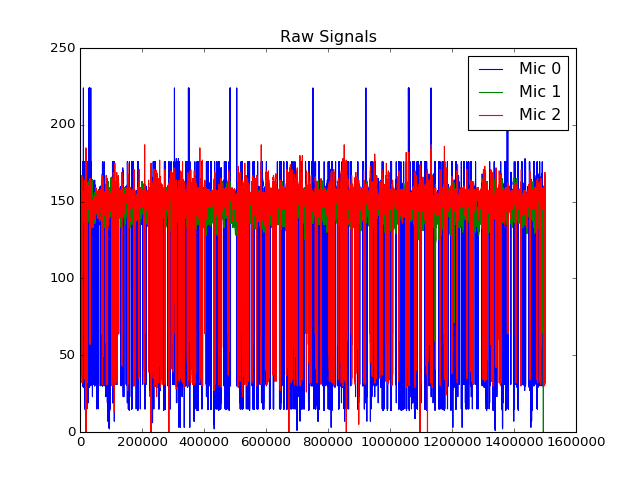

MIC_0: 5877
MIC_1: 20
MIC_2: 1932


In [26]:
a = mic_0[:1500000]
b = mic_1[:1500000]
c = mic_2[:1500000]

plt.figure()
plt.plot(a, label='Mic 0')
plt.plot(b, label='Mic 1')
plt.plot(c, label='Mic 2')
plt.title('Raw Signals')
plt.legend()
plt.show()

count = 0
for i in range(len(a)):
    if a[i] < 100 or a[i] > 175:
        count += 1
        
print 'MIC_0: %d' % count

count = 0
for i in range(len(b)):
    if b[i] < 100 or b[i] > 175:
        count += 1
        
print 'MIC_1: %d' % count

count = 0
for i in range(len(c)):
    if c[i] < 100 or c[i] > 175:
        count += 1
        
print 'MIC_2: %d' % count


<IPython.core.display.Javascript object>


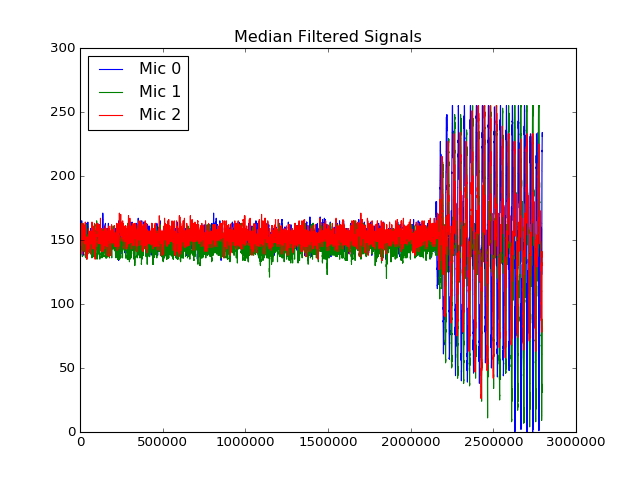

In [27]:
# Plot median filtered signal
mic_0_med = locate.median_filter(mic_0, window=MED_WINDOW_SIZE)
mic_1_med = locate.median_filter(mic_1, window=MED_WINDOW_SIZE)
mic_2_med = locate.median_filter(mic_2, window=MED_WINDOW_SIZE)

plt.figure()
plt.plot(mic_0_med, label='Mic 0')
plt.plot(mic_1_med, label='Mic 1')
plt.plot(mic_2_med, label='Mic 2')
plt.title('Median Filtered Signals')
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


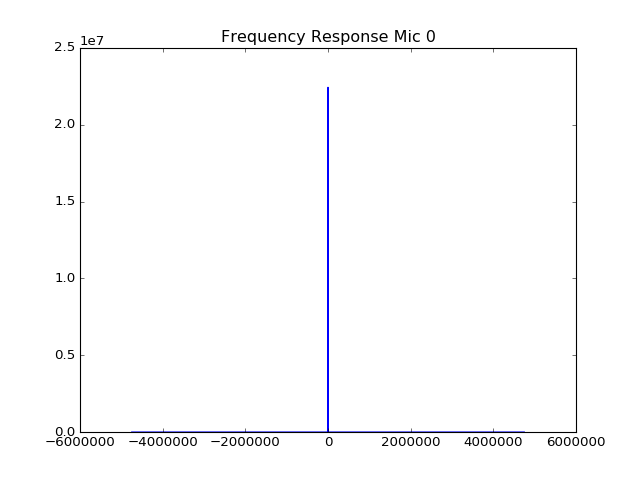

<IPython.core.display.Javascript object>


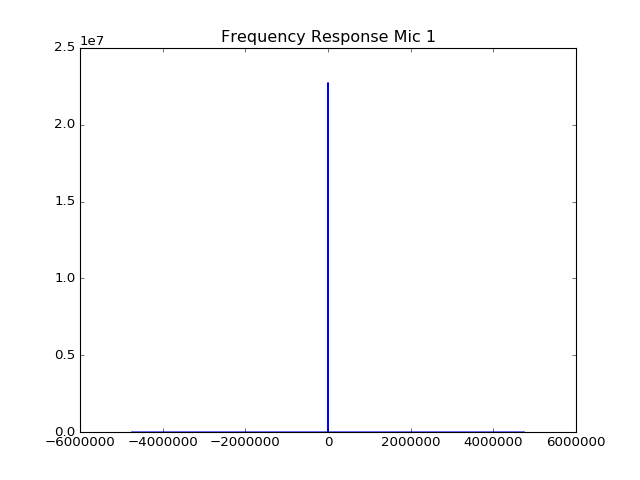

<IPython.core.display.Javascript object>


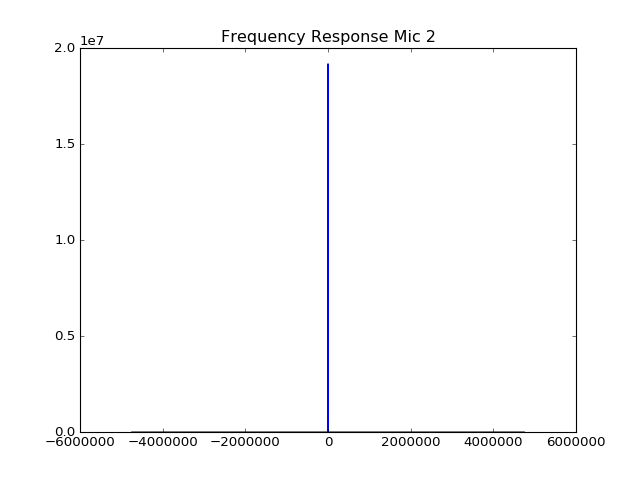

In [28]:
MIC_0 = np.fft.fftshift(np.fft.fft(locate.apply_ideal_bp(FREQ_1, FREQ_2, SAMPLING_FREQ, mic_0_med)))
freq = np.fft.fftshift(np.fft.fftfreq(len(mic_0_med), d=1./SAMPLING_FREQ))
plt.figure()
plt.plot(freq, np.abs(MIC_0))
plt.title('Frequency Response Mic 0')
plt.show()

MIC_1 = np.fft.fftshift(np.fft.fft(locate.apply_ideal_bp(FREQ_1, FREQ_2, SAMPLING_FREQ, mic_1_med)))
freq = np.fft.fftshift(np.fft.fftfreq(len(mic_1_med), d=1./SAMPLING_FREQ))
plt.figure()
plt.plot(freq, np.abs(MIC_1))
plt.title('Frequency Response Mic 1')
plt.show()

MIC_2 = np.fft.fftshift(np.fft.fft(locate.apply_ideal_bp(FREQ_1, FREQ_2, SAMPLING_FREQ, mic_2_med)))
freq = np.fft.fftshift(np.fft.fftfreq(len(mic_2_med), d=1./SAMPLING_FREQ))
plt.figure()
plt.plot(freq, np.abs(MIC_2))
plt.title('Frequency Response Mic 2')
plt.show()

In [29]:
# Crop the signals
sigs = [mic_0, mic_1, mic_2]
sigs_cropped, sigs_butter_cropped, offsets, sigs_win, peak_idx = crop_sigs(sigs)

print offsets
print peak_idx

[1610314 1622484 1617165]
[array([1682314, 1718398]), array([1694484, 1730088]), array([1689165, 1725733])]


<IPython.core.display.Javascript object>


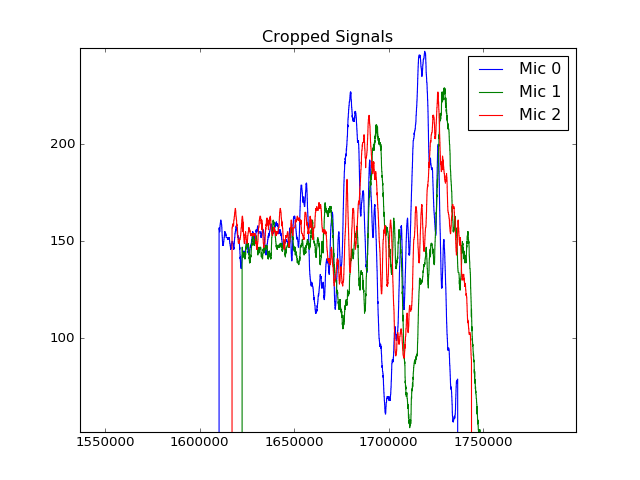

<IPython.core.display.Javascript object>


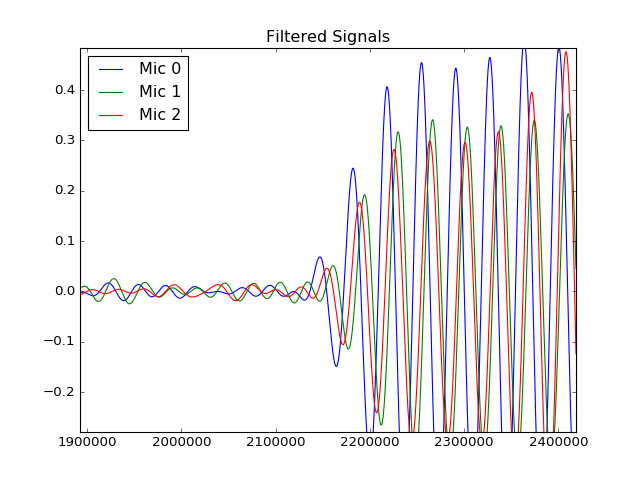

<IPython.core.display.Javascript object>


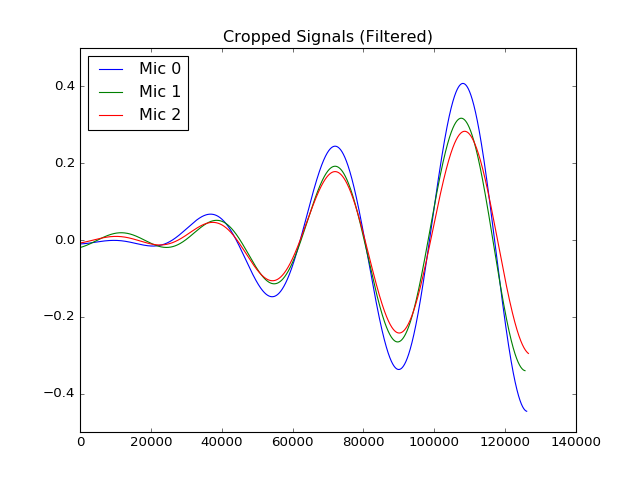

In [30]:
 # Display median filtered signals since xcorr_peaks median filters input
sigs_win = [locate.median_filter(sig) for sig in sigs_win]    

plt.figure()
plt.plot(sigs_win[0], label='Mic 0')
plt.plot(sigs_win[1], label='Mic 1')
plt.plot(sigs_win[2], label='Mic 2')
plt.title('Cropped Signals')
plt.legend(loc='best')
plt.show()

plt.figure()
sig_butters = [locate.normalize_signal(
    locate.apply_ideal_bp(
        locate.FREQ_1, locate.FREQ_2, locate.SAMPLING_FREQ, sig
    )
) for sig in sigs]
plt.plot(sig_butters[0], label='Mic 0')
plt.plot(sig_butters[1], label='Mic 1')
plt.plot(sig_butters[2], label='Mic 2')
plt.title('Filtered Signals')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.plot(sigs_butter_cropped[0], label='Mic 0')
plt.plot(sigs_butter_cropped[1], label='Mic 1')
plt.plot(sigs_butter_cropped[2], label='Mic 2')
plt.title('Cropped Signals (Filtered)')
plt.legend(loc='best')
plt.show()

In [31]:
print 'Mic 0 SNR: %f' % get_snr(sig_butters[0][locate.TRUNC_WINDOW:])
print 'Mic 1 SNR: %f' % get_snr(sig_butters[1][locate.TRUNC_WINDOW:])
print 'Mic 2 SNR: %f' % get_snr(sig_butters[2][locate.TRUNC_WINDOW:])

Mic 0 SNR: 30.974760
Mic 1 SNR: 22.753095
Mic 2 SNR: 23.706668


/home/jtmzheng/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/jtmzheng/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app
/home/jtmzheng/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


<IPython.core.display.Javascript object>


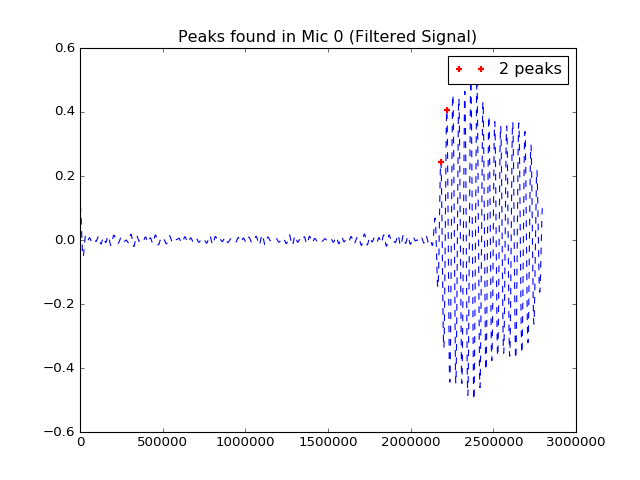

<IPython.core.display.Javascript object>


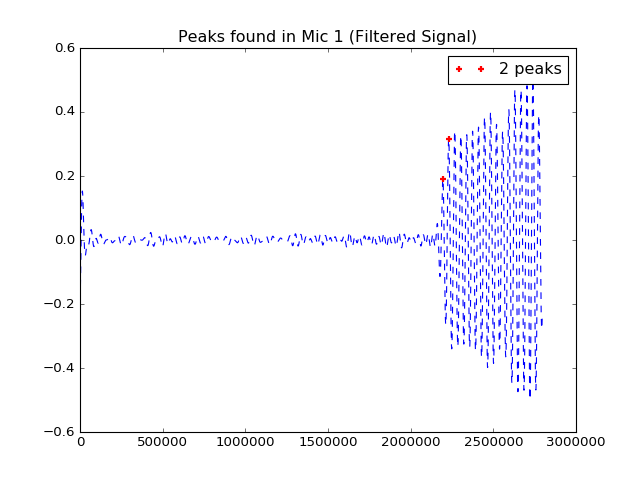

<IPython.core.display.Javascript object>


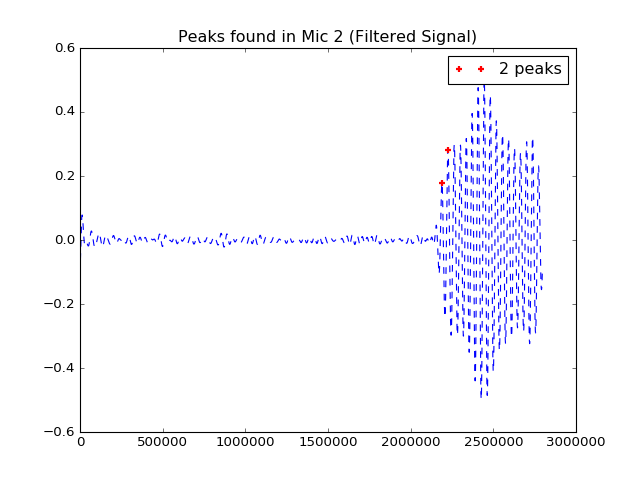

In [32]:
#Plot the peaks we find
plt.figure()
plt.title('Peaks found in Mic 0 (Filtered Signal)')
pplot(np.arange(len(sig_butters[0])), sig_butters[0], peak_idx[0] + TRUNC_WINDOW)
plt.show()

plt.figure()
plt.title('Peaks found in Mic 1 (Filtered Signal)')
pplot(np.arange(len(sig_butters[1])), sig_butters[1], peak_idx[1] + TRUNC_WINDOW)
plt.show()

plt.figure()
plt.title('Peaks found in Mic 2 (Filtered Signal)')
pplot(np.arange(len(sig_butters[2])), sig_butters[2], peak_idx[2] + TRUNC_WINDOW)
plt.show()